# Css Analysis Youtube

In [38]:
# Package
import pandas as pd
import rustworkx as rw
import matplotlib.pyplot as plt
from plotnine import *
import pandasql as ps
from itertools import combinations

In [39]:
# Data loading
comment_df = pd.read_csv("data_retrival/youtube_database/comments_youtube_final.csv")
video_df = pd.read_csv("data_retrival/youtube_database/video_details_final.csv")

# Data pre-processing
comment_df = comment_df.dropna(subset=["author"])
video_df["comment_count"] = video_df["comment_count"].fillna(0)

In [40]:
#comment_df


In [41]:
#video_df

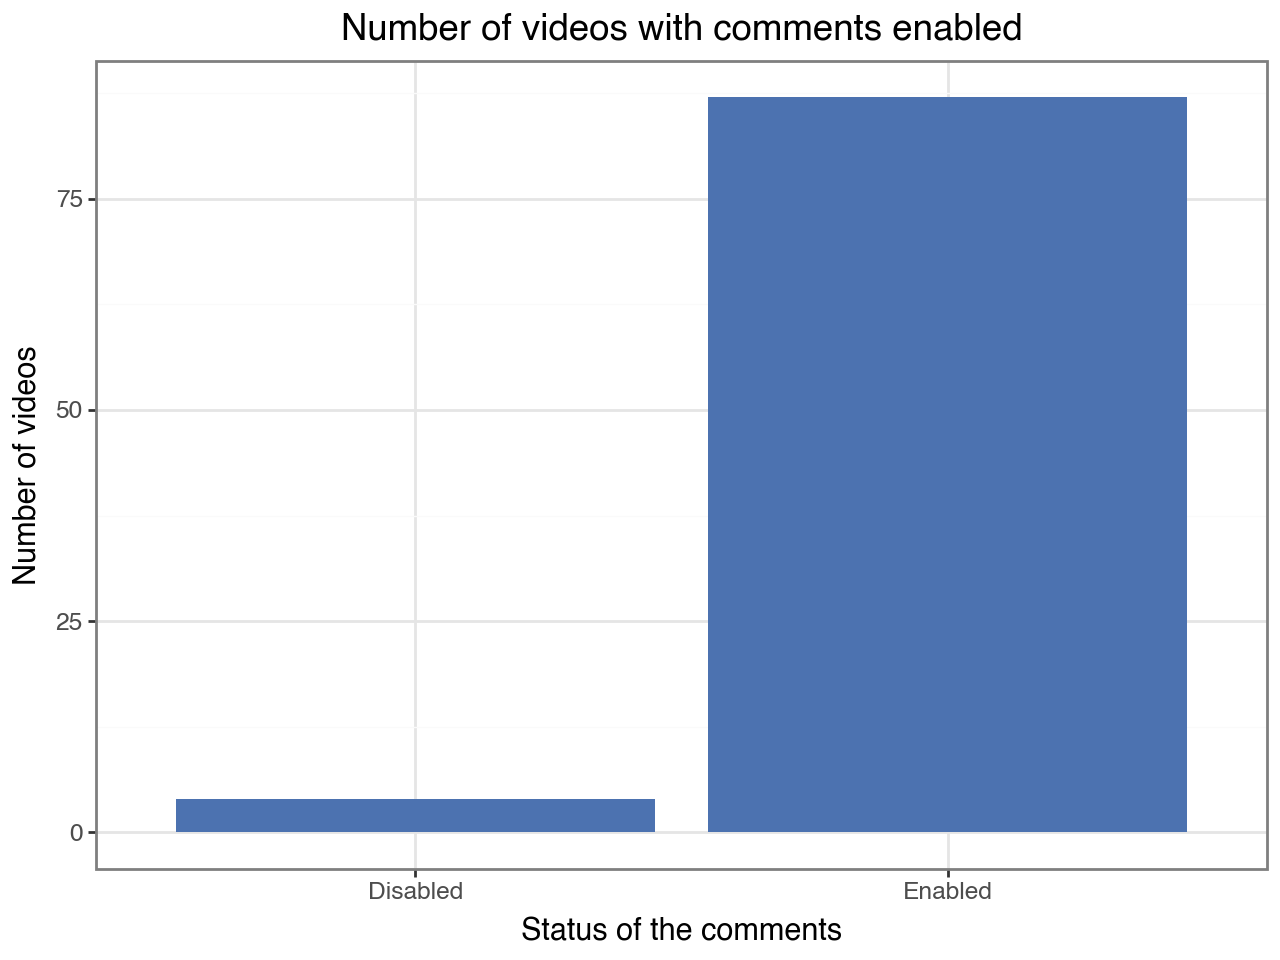

In [42]:
# Analysis of the video with comments
counter_no = (video_df["comment_count"] == 0).sum()
counter_yes = (video_df["comment_count"] > 0).sum()

# Crea un DataFrame per il barplot
comment_status_df = pd.DataFrame({
    'Comment_Status': ['Disabled', 'Enabled'],
    'Count': [counter_no, counter_yes]
})

# barplot
barplot = (
    ggplot(comment_status_df, aes(x='Comment_Status', y='Count')) +
    geom_bar(stat='identity', fill="#4C72B0") +
    theme_bw() +
    labs(
        title="Number of videos with comments enabled",
        x="Status of the comments",
        y="Number of videos"
    )
)
barplot

## Network Analysis
1) Verify the distribution on the videos to understand what are the most usefull videos
2) Get the hubs and select al the most informative videos

In [43]:
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# Prepara i dati
video_df["like_count"] = video_df["like_count"].fillna(0).astype(int)
video_df["comment_count"] = video_df["comment_count"].fillna(0).astype(int)
comment_df["like_count"] = comment_df["like_count"].fillna(0).astype(int)

author_likes = (
    comment_df.groupby("author")["like_count"]
    .sum()
    .reset_index()
    .rename(columns={"like_count": "total_likes"})
)

# Crea i plot singoli con plotnine
plot1 = (
    ggplot(video_df, aes(x="like_count"))
    + geom_histogram(aes(y=after_stat("density")), bins=100, fill="steelblue", color="black", alpha=0.6)
    + geom_density(color="red", size=1.2, adjust=0.25)
    + labs(title="Like per video", x="Like", y="Densità")
    + theme_bw()
)

plot2 = (
    ggplot(video_df, aes(x="comment_count"))
    + geom_histogram(aes(y=after_stat("density")), bins=100, fill="steelblue", color="black", alpha=0.6)
    + geom_density(color="red", size=1.2, adjust=0.25)
    + labs(title="Commenti per video", x="Commenti", y="Densità")
    + theme_bw()
)

# Funzione per convertire un plotnine plot in immagine PIL
def plot_to_image(p):
    buf = BytesIO()
    p.save(buf, format='png', verbose=False)
    buf.seek(0)
    return Image.open(buf)

# Converti ciascun plot in immagine
img1 = plot_to_image(plot1)
img2 = plot_to_image(plot2)

# Crea la figura matplotlib
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
for ax, img in zip(axs, [img1, img2]):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [7]:
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95]

# Prepara lista per raccogliere i risultati
results = []

for p in percentiles:
    threshold = video_df["comment_count"].quantile(p)
    subset = video_df[video_df["comment_count"] >= threshold]
    num_videos = len(subset)
    total_comments = subset["comment_count"].sum()
    
    results.append({
        "Percentile": f">= {int(p * 100)}°",
        "Soglia (commenti)": int(threshold),
        "Video rimanenti": num_videos,
        "Commenti totali": int(total_comments)
    })

summary_df = pd.DataFrame(results)
summary_df

,Percentile,Soglia (commenti),Video rimanenti,Commenti totali
0,>= 25°,535,68,515071
1,>= 50°,3219,46,472354
2,>= 75°,6265,23,364210
3,>= 90°,13728,10,245406
4,>= 95°,24188,5,155137


From this table we can see that many videos even if searched via relevavance and visualization, do not show a lot of comment, so the discussion in this sentiment in this videos can be avoided. In summary we have found the degree hubs to work on.

In [8]:
# Cut of the video dataset 
q75 = video_df["comment_count"].quantile(0.75)
filtered_video_df = video_df[video_df["comment_count"] >= q75].copy()

# Cut of the comment dataset 
video_ids_kept = filtered_video_df["video_id"].unique()
filtered_comment_df = comment_df[comment_df["video_id"].isin(video_ids_kept)].copy()


# Print of the dataset
print(f"Video rimanenti dopo il taglio del 75° percentile: {len(filtered_video_df)}")
print(filtered_video_df.head())

print(f"Commenti rimanenti dopo il filtro: {len(filtered_comment_df)}")
print(filtered_comment_df.head())



Video rimanenti dopo il taglio del 75° percentile: 23
       video_id                                              title  \
0   C1-OFLsgnOU  New video and details emerge from Parkland sho...   
21  xgIJosk0pnA         17 dead in 'horrific' high school shooting   
22  BmcSsc0TZxU  Florida school shooting survivors recall shots...   
32  qjCWa0rscB0  Security Video Shows Parkland School Shooter A...   
38  Z0vLiQLpsc8  Jimmy Kimmel on School Shooting in Parkland, F...   

                                          description          published_at  \
0   Surveillance video of Nikolas Cruz inside Marj...  2018-12-29T16:05:26Z   
21  Suspect Nikolas Cruz, 19, was taken into custo...  2018-02-15T14:43:40Z   
22  ABC News "World News Tonight" anchor David Mui...  2018-02-16T10:02:02Z   
32  Broward County Sgt. Raymond Beltran described ...  2022-07-27T16:15:02Z   
38  We are all reeling after yet another senseless...  2018-02-16T03:24:33Z   

        channel_title  view_count  like_count  com

Let's see if in this hubs there are people that discuss in every hubs

In [9]:
# Filtra i commenti sui soli video hub
video_hub_ids = filtered_video_df["video_id"].unique()
hub_comments = comment_df[comment_df["video_id"].isin(video_hub_ids)].copy()

# Conta quanti commenti ogni autore ha fatto per ogni video
hub_comments["comment_count_per_video"] = hub_comments.groupby(["author", "video_id"])["comment_id"].transform("count")

# Conta il numero totale di commenti per autore (su tutti gli hub)
hub_comments["total_comments"] = hub_comments.groupby("author")["comment_id"].transform("count")

# Conta su quanti video hub ha commentato ciascun autore
hub_comments["num_hubs_commented"] = hub_comments.groupby("author")["video_id"].transform("nunique")

# Elimina duplicati per coppie (author, video_id), così ogni riga è un autore per un video
result_df = hub_comments.drop_duplicates(subset=["author", "video_id"])[
    ["author", "video_id", "comment_count_per_video", "total_comments", "num_hubs_commented"]
].reset_index(drop=True)

# Aggiungi i titoli dei video
result_df = result_df.merge(
    filtered_video_df[["video_id", "title"]],
    on="video_id",
    how="left"
)

# Riordina le colonne
result_df = result_df[
    ["author", "video_id", "title", "comment_count_per_video", "total_comments", "num_hubs_commented"]
]

# Visualizza il risultato
result_df


,author,video_id,title,comment_count_per_video,total_comments,num_hubs_commented
0,@virtual7insanity,C1-OFLsgnOU,New video and details emerge from Parkland sho...,2,2,1
1,@iselacorvera26,C1-OFLsgnOU,New video and details emerge from Parkland sho...,2,2,1
2,@newhorizon1355,C1-OFLsgnOU,New video and details emerge from Parkland sho...,1,2,2
3,@Cavalete08,C1-OFLsgnOU,New video and details emerge from Parkland sho...,1,1,1
4,@irfandiwan-i7n,C1-OFLsgnOU,New video and details emerge from Parkland sho...,1,1,1
...,...,...,...,...,...,...
202467,@tylorhenderson6338,ZaLh74eXTDo,CNN town hall in wake of Florida school shooting,1,1,1
202468,@shevanel7077,ZaLh74eXTDo,CNN town hall in wake of Florida school shooting,1,1,1
202469,@CoLovecraft,ZaLh74eXTDo,CNN town hall in wake of Florida school shooting,1,1,1
202470,@rpr8,ZaLh74eXTDo,CNN town hall in wake of Florida school shooting,1,1,1


In [10]:
# 1) Costruzione network commenti - video
## 1) creazione dataframe video_id comment_id
df_ids = filtered_comment_df[['video_id', 'author']]

# Graph creation
video_ids = df_ids["video_id"].unique().tolist()
author_ids = df_ids["author"].unique().tolist()

# Crea mappa per assegnare un intero a ciascun nodo (richiesto da rustworkx)
all_nodes = video_ids + author_ids
node_indices = {label: i for i, label in enumerate(all_nodes)}

# Crea grafo
full_graph = rw.PyGraph()
full_graph.add_nodes_from(all_nodes)

# Aggiungi archi tra author e video
for row in df_ids.itertuples(index=False):
    src = node_indices[row.author]
    tgt = node_indices[row.video_id]
    full_graph.add_edge(src, tgt, None)

full_graph

In [11]:
import pandas as pd

# Calcola i degree manualmente per ogni nodo
degrees = [full_graph.degree(i) for i in range(len(all_nodes))]

# Costruisci il DataFrame
degree_df = pd.DataFrame({
    "label": all_nodes,
    "degree": degrees
})

# Aggiungi colonna per distinguere video e autori
degree_df["type"] = degree_df["label"].apply(lambda x: "video" if x in video_ids else "author")

# Ordina per grado decrescente
degree_df = degree_df.sort_values(by="degree", ascending=False).reset_index(drop=True)

# Mostra i risultati
degree_df


,label,degree,type
0,RqAJn_BcWDk,30449,video
1,AqnBlquZB_M,20448,video
2,turCfxwkfPE,17020,video
3,xgIJosk0pnA,13456,video
4,yXePrX6vhs8,13375,video
...,...,...,...
187370,@susie5577,1,author
187371,@watermelon5203,1,author
187372,@therapissed3531,1,author
187373,@picklepunk7441,1,author


In [12]:
degree_df_author = degree_df[degree_df["type"] == "author"]
degree_df_author

,label,degree,type
23,@AJL630-c9k,66,author
24,@chadstickler4595,58,author
25,@angeljuarez1529,35,author
26,@benjif1380,34,author
27,@timothywait9457,34,author
...,...,...,...
187370,@susie5577,1,author
187371,@watermelon5203,1,author
187372,@therapissed3531,1,author
187373,@picklepunk7441,1,author


In [13]:
# Filtra i commenti scritti da un autore specifico
author_id = "@chadstickler4595"
author_comments = filtered_comment_df[filtered_comment_df["author"] == author_id].copy()

# Visualizza i primi commenti dell'autore
author_comments[["video_id", "text", "like_count", "published_at"]].head()



,video_id,text,like_count,published_at
584,C1-OFLsgnOU,They all enjoyed causing it a real pleasure fo...,0,2022-12-19T23:13:20Z
70177,qjCWa0rscB0,Don't mention how many bullied him interesting,0,2022-12-20T00:04:06Z
70178,qjCWa0rscB0,Yeah I remember mental health centers staff bu...,0,2022-12-20T00:00:27Z
70848,qjCWa0rscB0,Ha ha ha Chad the alien really gets bullied by...,0,2022-11-21T03:19:01Z
70849,qjCWa0rscB0,Yeah I couldn't pay my rent cause mental healt...,0,2022-11-21T03:18:28Z


# Clustering with LDA


In [49]:
df_complete = pd.read_csv("data_retrival/results/final_dataset.csv").dropna()
df_complete

,post_id,text,author,created_utc,source
1,8aa3jl,I think the conversation needs to recognise th...,Misgunception,2018-04-06T14:55:30Z,Reddit
2,8aa3jl,"So to eliminate gun violence, we need to remov...",Misgunception,2018-04-06T15:56:20Z,Reddit
3,8aa3jl,Spot on!I found it interesting that London and...,TooOldToTell,2018-04-06T19:09:01Z,Reddit
4,8aa3jl,very interesting that birtain is also tramplin...,starfishcannon,2018-04-07T00:43:27Z,Reddit
5,8aa3jl,Do you have evidence to back up this assertion?,Vernon_Roche1,2018-04-08T00:06:36Z,Reddit
...,...,...,...,...,...
231303,UgwjlSZMEUfb5bLI0ut4AaABAg,Adolf media group at work.,@rmkscrambler,2018-02-22T06:00:51Z,YouTube
231304,Ugzl29ygrpDKDh6G58l4AaABAg,CNN trying real hard for that Marxist America ...,@shevanel7077,2018-02-22T05:59:14Z,YouTube
231305,UgyAglp1DJnINf6fiod4AaABAg,My favorite part is when the career politician...,@CoLovecraft,2018-02-22T05:58:49Z,YouTube
231306,UgyDvo27iPzllB_gcbt4AaABAg,These parents and students... these a great pe...,@rpr8,2018-02-22T05:57:41Z,YouTube


LDA is a generative probabilistic model that represents documents as a mixture of topics. It assumes that each document exhibits multiple topics, and each topic is characterized by a distribution of words. To perform a great selection, we have to perform a grid search to find:
- number of topic
- doc_topic_prior
- topic_word_prior
Via the perplexity value we can evaluate the best combination

In [61]:
# Grid Search
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm
from joblib import Parallel, delayed
import itertools

# NLTK
nltk.download("punkt")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Preprocessing
def preprocess(text):
    tokens = word_tokenize(text.lower())
    return " ".join([t for t in tokens if t.isalpha() and t not in stop_words])

# Carica dati
df = pd.read_csv("data_retrival/results/final_dataset.csv").dropna()
df["clean_text"] = df["text"].astype(str).apply(preprocess)

# Bag-of-Words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
doc_term_matrix = vectorizer.fit_transform(df["clean_text"])

# Parametri da testare
param_grid = {
    "n_components": [2, 3, 4, 5, 6],
    "doc_topic_prior": [0.01, 0.1, 0.5,],     # alpha
    "topic_word_prior": [0.01, 0.1, 0.5 ]    # beta
}
param_combinations = list(itertools.product(
    param_grid["n_components"],
    param_grid["doc_topic_prior"],
    param_grid["topic_word_prior"]
))

# Funzione singola per job
def evaluate_lda(k, alpha, beta):
    lda = LatentDirichletAllocation(
        n_components=k,
        doc_topic_prior=alpha,
        topic_word_prior=beta,
        random_state=42
    )
    lda.fit(doc_term_matrix)
    perplexity = lda.perplexity(doc_term_matrix)
    return {
        "n_components": k,
        "alpha": alpha,
        "beta": beta,
        "perplexity": perplexity
    }

# Esecuzione parallela con progress bar
results = Parallel(n_jobs=-1)(
    delayed(evaluate_lda)(k, alpha, beta)
    for k, alpha, beta in tqdm(param_combinations)
)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matteomassari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matteomassari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 45/45 [05:24<00:00,  7.21s/it]


In [66]:
results_grid_search = pd.DataFrame(results).sort_values(by="perplexity")
print("\n📊 Top 5 combinazioni per perplexity:")
print(results_grid_search.head(5))

# Save the result
# results_grid_search.to_csv("data_retrival/result_grid_search.csv")


📊 Top 5 combinazioni per perplexity:
    n_components  alpha  beta   perplexity
22             4    0.1   0.1  2285.850720
23             4    0.1   0.5  2309.574615
40             6    0.1   0.1  2311.576211
31             5    0.1   0.1  2316.152812
25             4    0.5   0.1  2319.318199


In [67]:
results_grid_search

,n_components,alpha,beta,perplexity
22,4,0.10,0.10,2285.850720
23,4,0.10,0.50,2309.574615
40,6,0.10,0.10,2311.576211
31,5,0.10,0.10,2316.152812
25,4,0.50,0.10,2319.318199
13,3,0.10,0.10,2323.899110
14,3,0.10,0.50,2330.895954
21,4,0.10,0.01,2350.663465
16,3,0.50,0.10,2351.511287
32,5,0.10,0.50,2358.894737


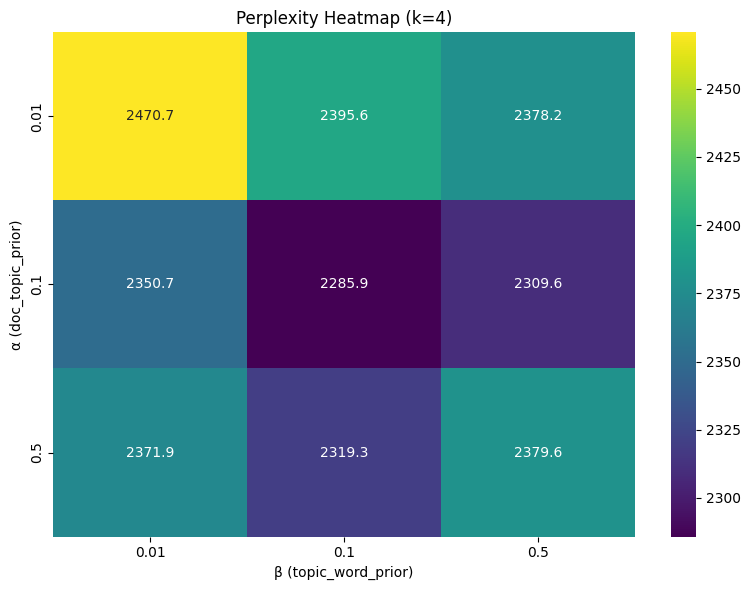

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

subset = results_grid_search[results_grid_search["n_components"] == 4]
pivot_table = subset.pivot(index="alpha", columns="beta", values="perplexity")

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="viridis")
plt.title("Perplexity Heatmap (k=4)")
plt.xlabel("β (topic_word_prior)")
plt.ylabel("α (doc_topic_prior)")
plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matteomassari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matteomassari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
⚙️ Grid Search (parallel): 100%|██████████| 9/9 [00:00<00:00, 5936.27it/s]



📊 Risultati:
🔹 Topic=2 → Perplexity=2392.94
🔹 Topic=3 → Perplexity=2323.90
🔹 Topic=4 → Perplexity=2285.85
🔹 Topic=5 → Perplexity=2316.15
🔹 Topic=6 → Perplexity=2311.58
🔹 Topic=7 → Perplexity=2339.54
🔹 Topic=8 → Perplexity=2343.51
🔹 Topic=9 → Perplexity=2373.90
🔹 Topic=10 → Perplexity=2401.01


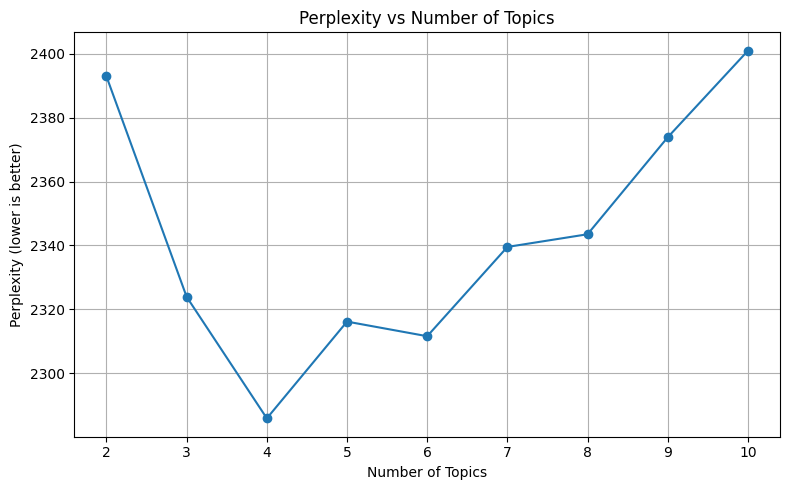

In [53]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from tqdm import tqdm

# Scarica risorse
nltk.download("punkt")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Preprocessing
def preprocess(text):
    tokens = word_tokenize(text.lower())
    return " ".join([t for t in tokens if t.isalpha() and t not in stop_words])

# Caricamento e preprocessing
df_subset = df_complete.copy()
tqdm.pandas(desc="🔄 Preprocessing")
df_subset["clean_text"] = df_subset["text"].astype(str).progress_apply(preprocess)

# Bag of Words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
doc_term_matrix = vectorizer.fit_transform(df_subset["clean_text"])

# Range di topic da testare
ks = list(range(2, 11))

# Funzione per addestrare e calcolare la perplexity
def evaluate_model(k):
    lda = LatentDirichletAllocation(
        n_components=k,
        random_state=42,
        doc_topic_prior=0.1,
        topic_word_prior=0.1,
        n_jobs=-1  # anche l'addestramento LDA è parallelo
    )
    lda.fit(doc_term_matrix)
    return k, lda.perplexity(doc_term_matrix)

# Parallelizzazione
results_topic_search = Parallel(n_jobs=-1)(
    delayed(evaluate_model)(k) for k in tqdm(ks, desc="⚙️ Grid Search (parallel)")
)

# Ordina e separa
results_topic_search.sort()
ks_sorted, perplexities = zip(*results)

# Stampa risultati
print("\n📊 Risultati:")
for k, p in results:
    print(f"🔹 Topic={k} → Perplexity={p:.2f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(ks_sorted, perplexities, marker="o")
plt.title("Perplexity vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity (lower is better)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:
results_topic_search = results

In [111]:
# LDA fine-tuned
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm

# Scarica risorse NLTK
nltk.download("punkt")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# tqdm per Pandas
tqdm.pandas()

# Funzione di pre-processing
def preprocess(text):
    tokens = word_tokenize(text.lower())
    return " ".join([t for t in tokens if t.isalpha() and t not in stop_words])

# Caricamento e pre-processing
df = pd.read_csv("data_retrival/results/final_dataset.csv").dropna()
df["clean_text"] = df["text"].astype(str).progress_apply(preprocess)

# Bag of Words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
doc_term_matrix = vectorizer.fit_transform(df["clean_text"])

# Addestramento modello LDA
num_topics = 4
lda_model = LatentDirichletAllocation(
        n_components=num_topics,
        random_state=42,
        doc_topic_prior=0.1,
        topic_word_prior=0.1,
    )
lda_model.fit(doc_term_matrix)

# Trova topic dominante per ogni documento
topic_distributions = lda_model.transform(doc_term_matrix)
df["dominant_topic"] = topic_distributions.argmax(axis=1)

# Visualizza i topic (le 10 parole principali per ciascun topic)
terms = vectorizer.get_feature_names_out()
print("\nTop words per topic:")
for idx, topic in tqdm(enumerate(lda_model.components_), total=num_topics):
    top_words = [terms[i] for i in topic.argsort()[-10:][::-1]]
    print(f"Topic {idx}: {' | '.join(top_words)}")

# Salva il dataset originale con il topic dominante
df_original = pd.read_csv("data_retrival/results/final_dataset.csv").dropna()
df_original["dominant_topic"] = df["dominant_topic"]  # attacca la colonna
df_original.to_csv("data_retrival/final_dataset_with_topic.csv", index=False)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matteomassari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matteomassari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 231067/231067 [00:17<00:00, 13226.54it/s]



Top words per topic:


100%|██████████| 4/4 [00:00<00:00, 573.72it/s]

Topic 0: sorry | god | sad | feel | hope | love | people | heart | families | know
Topic 1: school | shooting | like | kids | day | shooter | people | know | got | going
Topic 2: judge | like | kid | children | guy | defense | court | lawyers | cruz | said
Topic 3: people | gun | guns | death | need | like | america | penalty | think | stop


The topic extracted via the fine-tuned LDA where:

- Topic 0: sorry | god | sad | feel | hope | love | people | heart | families | know
- Topic 1: school | shooting | like | kids | day | shooter | people | know | got | going
- Topic 2: judge | like | kid | children | guy | defense | court | lawyers | cruz | said
- Topic 3: people | gun | guns | death | need | like | america | penalty | think | stop

In [128]:
# Now the dataset complete is
data_with_topics = pd.read_csv("data_retrival/results/final_dataset_with_topic.csv")

# Parsing della data
data_with_topics["created_utc"] = pd.to_datetime(data_with_topics["created_utc"])
data_with_topics["day"] = data_with_topics["created_utc"].dt.date
data_with_topics["month"] = data_with_topics["created_utc"].dt.to_period("M").dt.to_timestamp()
data_with_topics["year"] = data_with_topics["created_utc"].dt.year

data_with_topics


/var/folders/jl/654jv9hd1gjd2cryn_0qfrqc0000gn/T/ipykernel_37221/263530471.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.


,post_id,text,author,created_utc,source,dominant_topic,day,month,year
0,8aa3jl,I think the conversation needs to recognise th...,Misgunception,2018-04-06 14:55:30+00:00,Reddit,3,2018-04-06,2018-04-01,2018
1,8aa3jl,"So to eliminate gun violence, we need to remov...",Misgunception,2018-04-06 15:56:20+00:00,Reddit,3,2018-04-06,2018-04-01,2018
2,8aa3jl,Spot on!I found it interesting that London and...,TooOldToTell,2018-04-06 19:09:01+00:00,Reddit,3,2018-04-06,2018-04-01,2018
3,8aa3jl,very interesting that birtain is also tramplin...,starfishcannon,2018-04-07 00:43:27+00:00,Reddit,2,2018-04-07,2018-04-01,2018
4,8aa3jl,Do you have evidence to back up this assertion?,Vernon_Roche1,2018-04-08 00:06:36+00:00,Reddit,3,2018-04-08,2018-04-01,2018
...,...,...,...,...,...,...,...,...,...
231062,UgwjlSZMEUfb5bLI0ut4AaABAg,Adolf media group at work.,@rmkscrambler,2018-02-22 06:00:51+00:00,YouTube,3,2018-02-22,2018-02-01,2018
231063,Ugzl29ygrpDKDh6G58l4AaABAg,CNN trying real hard for that Marxist America ...,@shevanel7077,2018-02-22 05:59:14+00:00,YouTube,3,2018-02-22,2018-02-01,2018
231064,UgyAglp1DJnINf6fiod4AaABAg,My favorite part is when the career politician...,@CoLovecraft,2018-02-22 05:58:49+00:00,YouTube,3,2018-02-22,2018-02-01,2018
231065,UgyDvo27iPzllB_gcbt4AaABAg,These parents and students... these a great pe...,@rpr8,2018-02-22 05:57:41+00:00,YouTube,0,2018-02-22,2018-02-01,2018


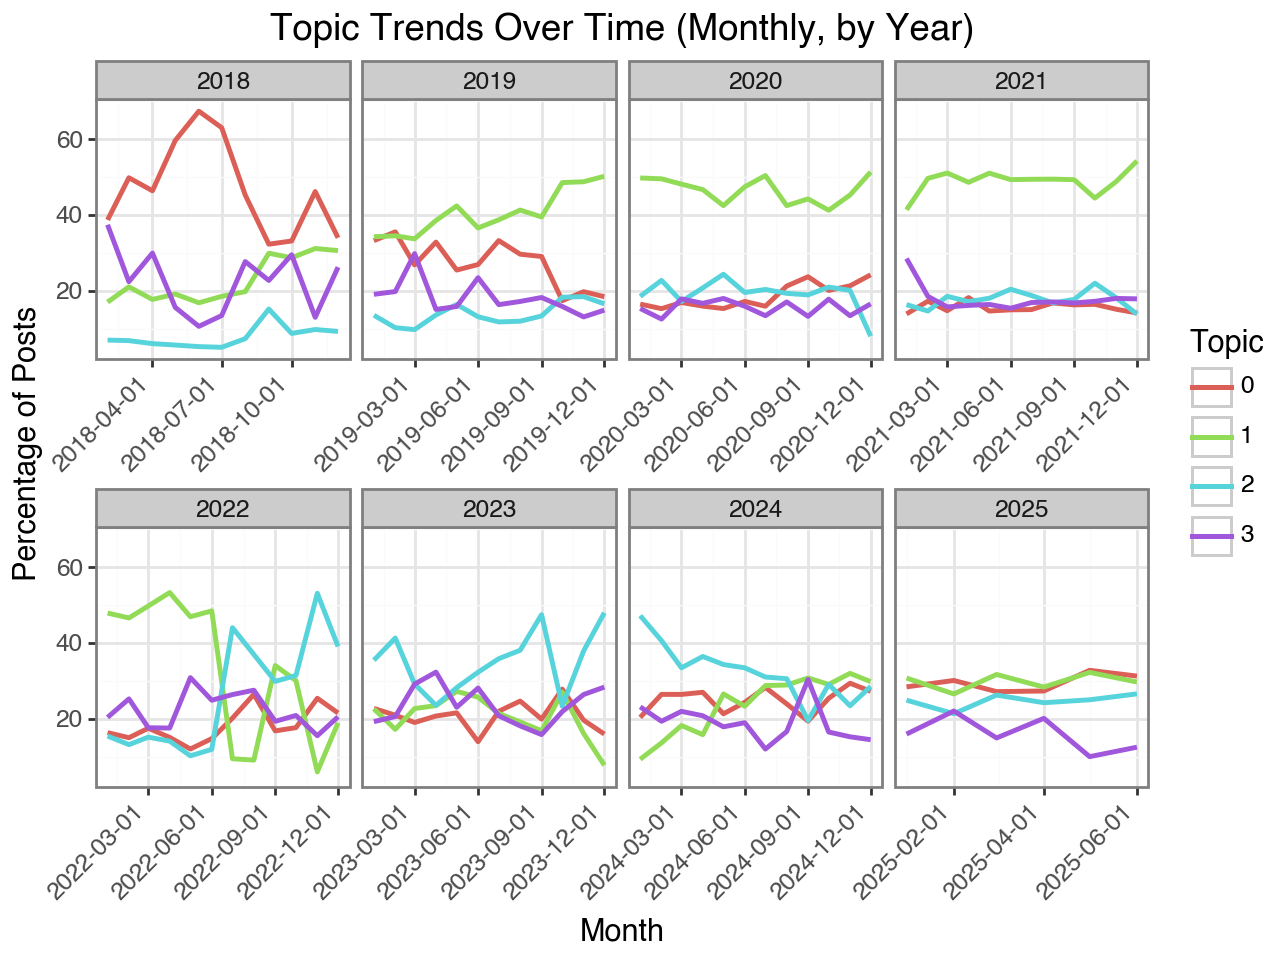

In [129]:
# Topics trend over time

# Count the observation
counts = (
    data_with_topics.groupby(["year", "month", "dominant_topic"])
    .size()
    .reset_index(name="count")
)

# Calcolo percentuale per mese
counts["total_per_month"] = counts.groupby(["year", "month"])["count"].transform("sum")
counts["percentage"] = counts["count"] / counts["total_per_month"] * 100

# Plot mensile per anno
plot = (
    ggplot(counts, aes(x="month", y="percentage", color="factor(dominant_topic)"))
    + geom_line(size=1)
    + facet_wrap("~year", scales="free_x", ncol=4)
    + labs(
        title="Topic Trends Over Time (Monthly, by Year)",
        x="Month",
        y="Percentage of Posts",
        color="Topic"
    )
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Salvataggio del grafico
#plot.save("topic_trends_by_year.png", dpi=300, width=20, height=10, units="in")
plot

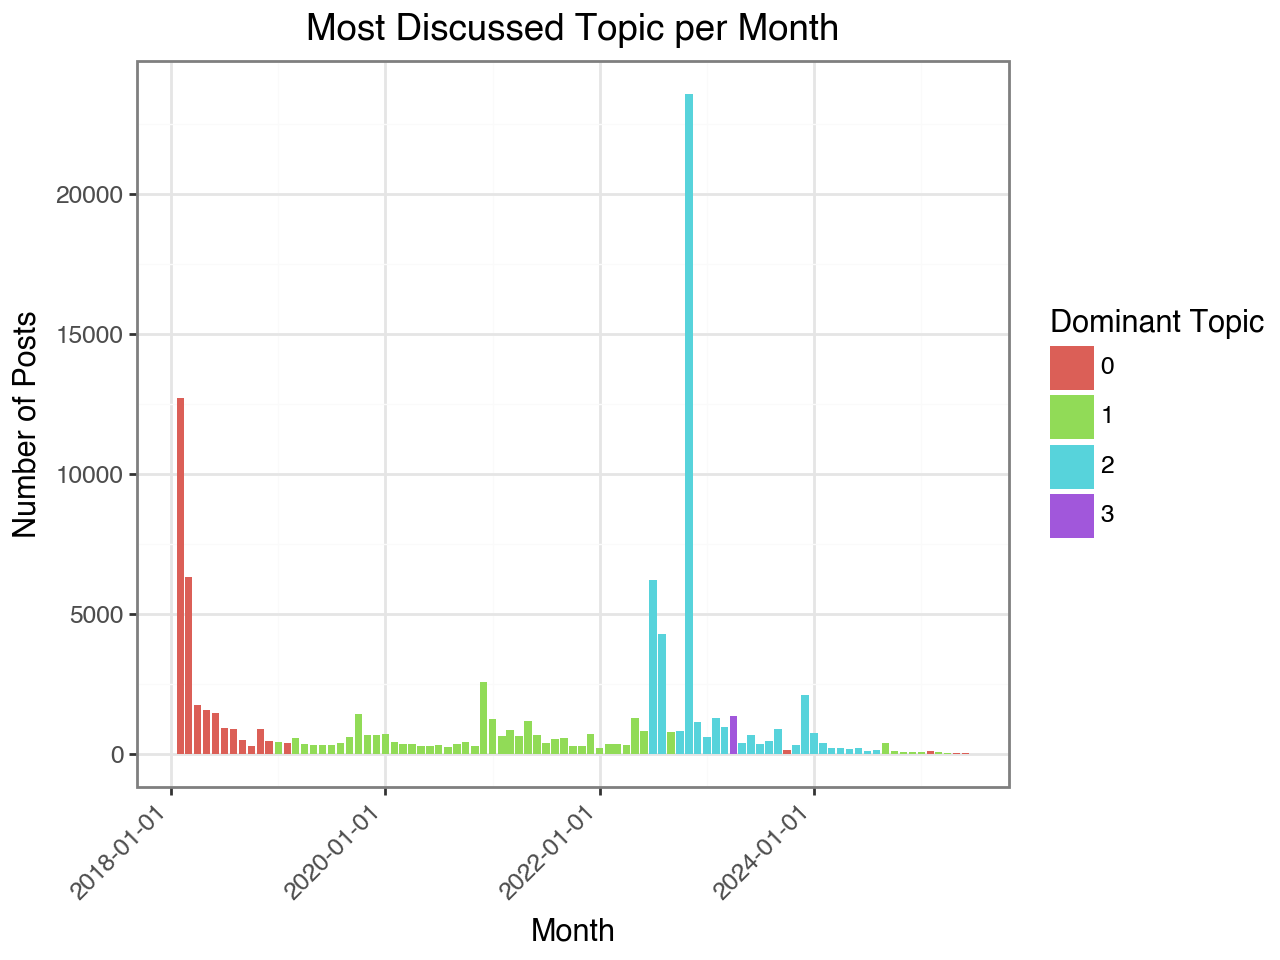

In [131]:
# Most Discussed Topic per Month
# Conta i post per mese e topic
topic_counts = (
    data_with_topics
    .groupby(["month", "dominant_topic"])
    .size()
    .reset_index(name="count")
)

# Trova il topic più discusso per ogni mese
most_talked = (
    topic_counts
    .sort_values("count", ascending=False)
    .groupby("month")
    .first()
    .reset_index()
)

# Grafico
plot = (
    ggplot(most_talked, aes(x="month", y="count", fill="factor(dominant_topic)"))
    + geom_col()
    + labs(
        title="Most Discussed Topic per Month",
        x="Month",
        y="Number of Posts",
        fill="Dominant Topic"
    )
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

#plot.save("most_discussed_topic_per_month.png", dpi=300, width=16, height=6, units="in")
plot


In [140]:
# First peek
mask = (
    (data_with_topics["created_utc"] >= "2018-02-14") &
    (data_with_topics["created_utc"] < "2018-04-14") &
    (data_with_topics["dominant_topic"] == 2)
)
shooting_dataset = data_with_topics[mask]

shooting_dataset["created_utc"] = pd.to_datetime(shooting_dataset["created_utc"], errors="coerce", utc=True)




/var/folders/jl/654jv9hd1gjd2cryn_0qfrqc0000gn/T/ipykernel_37221/3076758056.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [147]:
# LDA per nov_dec
# Grid Search
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm
from joblib import Parallel, delayed
import itertools

# NLTK
nltk.download("punkt")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Preprocessing
def preprocess(text):
    tokens = word_tokenize(text.lower())
    return " ".join([t for t in tokens if t.isalpha() and t not in stop_words])

# preprocess dei dati
shooting_dataset["clean_text"] = shooting_dataset["text"].astype(str).apply(preprocess)

# Bag-of-Words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
doc_term_matrix = vectorizer.fit_transform(shooting_dataset["clean_text"])

# Parametri da testare
param_grid = {
    "n_components": [1, 2, 3, 4, 5, 6],
    "doc_topic_prior": [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5],   # alpha
    "topic_word_prior": [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]   # beta
}
param_combinations = list(itertools.product(
    param_grid["n_components"],
    param_grid["doc_topic_prior"],
    param_grid["topic_word_prior"]
))

# Funzione singola per job
def evaluate_lda(k, alpha, beta):
    lda = LatentDirichletAllocation(
        n_components=k,
        doc_topic_prior=alpha,
        topic_word_prior=beta,
        random_state=42
    )
    lda.fit(doc_term_matrix)
    perplexity = lda.perplexity(doc_term_matrix)
    return {
        "n_components": k,
        "alpha": alpha,
        "beta": beta,
        "perplexity": perplexity
    }

# Esecuzione parallela con progress bar
results_nov_dec = Parallel(n_jobs=-1)(
    delayed(evaluate_lda)(k, alpha, beta)
    for k, alpha, beta in tqdm(param_combinations)
)

results_nov_dec_df = pd.DataFrame(results_nov_dec).sort_values(by="perplexity")
print("\n📊 Top 5 combinazioni per perplexity:")
print(results_nov_dec_df.head(5))



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matteomassari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matteomassari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/jl/654jv9hd1gjd2cryn_0qfrqc0000gn/T/ipykernel_37221/3285559015.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 245/245 [00:34<00:00,  7.07it/s]



📊 Top 5 combinazioni per perplexity:
    n_components  alpha  beta   perplexity
20             2  0.010   0.5  1248.969978
13             2  0.005   0.5  1252.433366
27             2  0.050   0.5  1256.427113
6              2  0.001   0.5  1261.135940
34             2  0.100   0.5  1267.016148


In [148]:
# LDA fine-tuned
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm

# Scarica risorse NLTK
nltk.download("punkt")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# tqdm per Pandas
tqdm.pandas()

# Funzione di pre-processing
def preprocess(text):
    tokens = word_tokenize(text.lower())
    return " ".join([t for t in tokens if t.isalpha() and t not in stop_words])

# Caricamento e pre-processing
shooting_dataset["clean_text"] = shooting_dataset["text"].astype(str).progress_apply(preprocess)

# Bag of Words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
doc_term_matrix = vectorizer.fit_transform(shooting_dataset["clean_text"])

# Addestramento modello LDA
lda_model = LatentDirichletAllocation(
        n_components=2,
        random_state=42,
        doc_topic_prior=0.01,
        topic_word_prior=0.5,
    )
lda_model.fit(doc_term_matrix)

# Trova topic dominante per ogni documento
topic_distributions = lda_model.transform(doc_term_matrix)
shooting_dataset["dominant_topic"] = topic_distributions.argmax(axis=1)

# Visualizza i topic (le 10 parole principali per ciascun topic)
terms = vectorizer.get_feature_names_out()
print("\nTop words per topic:")
for idx, topic in tqdm(enumerate(lda_model.components_), total=num_topics):
    top_words = [terms[i] for i in topic.argsort()[-15:][::-1]]
    print(f"Topic {idx}: {' | '.join(top_words)}")

# Salva il dataset originale con il topic dominante
shooting_dataset_context = shooting_dataset.copy()

shooting_dataset_context["dominant_topic"] = shooting_dataset_context["dominant_topic"]  # attacca la colonna
shooting_dataset_context.to_csv("data_retrival/shooting_dataset_context.csv", index=False)




[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matteomassari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matteomassari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

100%|██████████| 3309/3309 [00:00<00:00, 17933.99it/s]
/var/folders/jl/654jv9hd1gjd2cryn_0qfrqc0000gn/T/ipykernel_37221/1366652493.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/jl/654jv9hd1gjd2cryn_0qfrqc0000gn/T/ipykernel_37221/1366652493.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan


Top words per topic:



 50%|█████     | 2/4 [00:00<00:00, 7626.01it/s]

Topic 0: like | people | kid | guy | kids | good | cruz | got | wrong | said | ass | shooter | know | make | going
Topic 1: like | na | gon | lol | man | watch | really | video | children | people | say | comment | damn | guy | know


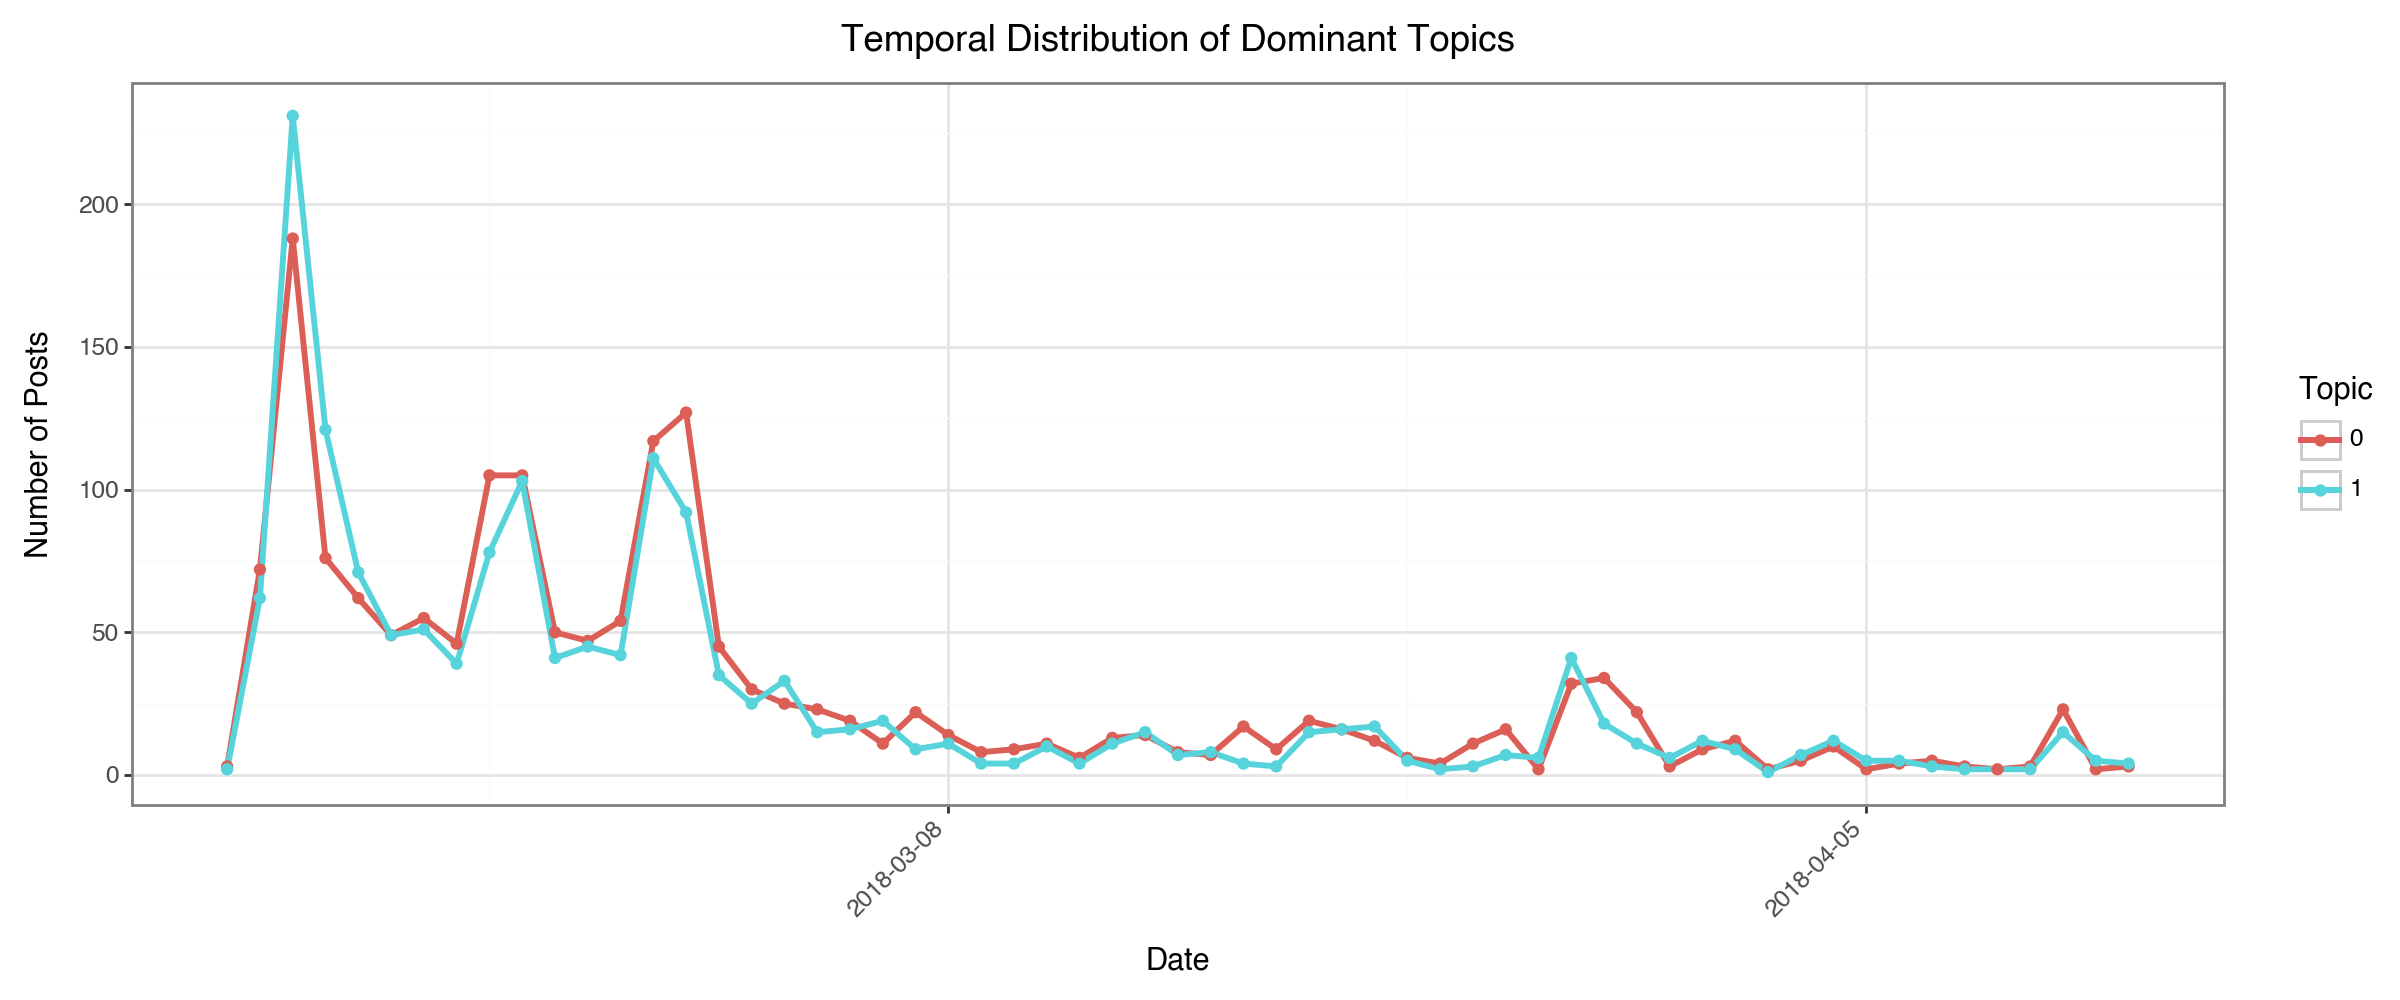

In [149]:
import pandas as pd
from plotnine import *
from mizani.formatters import date_format

# Convert datetime and extract the day
shooting_dataset_context["created_utc"] = pd.to_datetime(shooting_dataset_context["created_utc"])
shooting_dataset_context["day"] = shooting_dataset_context["created_utc"].dt.date

# Count posts per day and dominant topic
daily_counts = shooting_dataset_context.groupby(["day", "dominant_topic"]).size().reset_index(name="count")
daily_counts["day"] = pd.to_datetime(daily_counts["day"])

# Plot
plot = (
    ggplot(daily_counts, aes(x="day", y="count", color="factor(dominant_topic)"))
    + geom_line(size=1.2)
    + geom_point(size=1.5)
    + labs(
        title="Temporal Distribution of Dominant Topics",
        x="Date",
        y="Number of Posts",
        color="Topic"
    )
    + scale_x_datetime(
        labels=date_format("%Y-%m-%d"),
        date_breaks="4 weeks"  # change to "1 month" for even fewer labels
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, ha="right"),
        figure_size=(12, 5)
    )
)

plot


In [135]:
# Second peek
# Analysis of the trial

# Filtra solo i post di novembre e dicembre 2022 per topic 2
mask = (
    (data_with_topics["created_utc"] >= "2022-11-01") &
    (data_with_topics["created_utc"] < "2023-01-01") &
    (data_with_topics["dominant_topic"] == 2)
)
trial_dataset = data_with_topics[mask]

trial_dataset["created_utc"] = pd.to_datetime(trial_dataset["created_utc"], errors="coerce", utc=True)





/var/folders/jl/654jv9hd1gjd2cryn_0qfrqc0000gn/T/ipykernel_37221/3657990499.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [136]:
trial_dataset

,post_id,text,author,created_utc,source,dominant_topic,day,month,year
16225,UgwYy4ohKTOaKRC2uuB4AaABAg,Honestly with my instincts (I’m not blaming th...,@DustedAway,2022-12-26 03:40:13+00:00,YouTube,2,2022-12-26,2022-12-01,2022
16227,UgySJ0zRNJZU1V-YJfB4AaABAg,That kid in the blue had to have been the one ...,@BradyDoesntMiss,2022-12-24 05:37:49+00:00,YouTube,2,2022-12-24,2022-12-01,2022
16230,Ugw_uXYU7m7phru0jrB4AaABAg,If I was the blue guy I’d get up behind him an...,@justakid3592,2022-12-23 06:06:28+00:00,YouTube,2,2022-12-23,2022-12-01,2022
16231,UgzwKBu1XA3hXjgXLgt4AaABAg,be fr why would you tackle sb with a AR 🤦🏼‍♀,@itsbrigary,2022-12-22 17:41:44+00:00,YouTube,2,2022-12-22,2022-12-01,2022
16240,UgyOzUNbLxJs3YTSP-Z4AaABAg,That kid could of tackled him form behide,@Rigo_alpachino505,2022-12-20 07:49:28+00:00,YouTube,2,2022-12-20,2022-12-01,2022
...,...,...,...,...,...,...,...,...,...
222162,Ugxl8qgV2Jpa-AKSxtJ4AaABAg,does anybody know if this detective took the s...,@bigbirdflying6330,2022-11-02 08:22:18+00:00,YouTube,2,2022-11-02,2022-11-01,2022
222166,Ugwe7-NOFXSEjbz_doJ4AaABAg,He's gonna go like Jeffrey Dahmer. I hope he g...,@Obiter3,2022-11-01 22:23:19+00:00,YouTube,2,2022-11-01,2022-11-01,2022
222168,Ugzk2C31SBnnPKsUgO94AaABAg,is he always strapped down or is he hurting hi...,@amabelisalinas364,2022-11-01 17:36:07+00:00,YouTube,2,2022-11-01,2022-11-01,2022
224484,UgyHzTjbn6W6Kibdu7h4AaABAg,Did anyone else notice little BALD HEADED MEDI...,@twolak1972,2022-12-31 15:38:54+00:00,YouTube,2,2022-12-31,2022-12-01,2022


In [146]:
# LDA per nov_dec
# Grid Search
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm
from joblib import Parallel, delayed
import itertools

# NLTK
nltk.download("punkt")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Preprocessing
def preprocess(text):
    tokens = word_tokenize(text.lower())
    return " ".join([t for t in tokens if t.isalpha() and t not in stop_words])

# preprocess dei dati
trial_dataset["clean_text"] = trial_dataset["text"].astype(str).apply(preprocess)

# Bag-of-Words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
doc_term_matrix = vectorizer.fit_transform(trial_dataset["clean_text"])

# Parametri da testare
param_grid = {
    "n_components": [1, 2, 3, 4, 5,],
    "doc_topic_prior": [0.01, 0.1, 0.5,],     # alpha
    "topic_word_prior": [0.01, 0.1, 0.5 ]    # beta
}
param_combinations = list(itertools.product(
    param_grid["n_components"],
    param_grid["doc_topic_prior"],
    param_grid["topic_word_prior"]
))

# Funzione singola per job
def evaluate_lda(k, alpha, beta):
    lda = LatentDirichletAllocation(
        n_components=k,
        doc_topic_prior=alpha,
        topic_word_prior=beta,
        random_state=42
    )
    lda.fit(doc_term_matrix)
    perplexity = lda.perplexity(doc_term_matrix)
    return {
        "n_components": k,
        "alpha": alpha,
        "beta": beta,
        "perplexity": perplexity
    }

# Esecuzione parallela con progress bar
results_nov_dec = Parallel(n_jobs=-1)(
    delayed(evaluate_lda)(k, alpha, beta)
    for k, alpha, beta in tqdm(param_combinations)
)

results_nov_dec_df = pd.DataFrame(results_nov_dec).sort_values(by="perplexity")
print("\n📊 Top 5 combinazioni per perplexity:")
print(results_nov_dec_df.head(5))



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matteomassari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matteomassari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/jl/654jv9hd1gjd2cryn_0qfrqc0000gn/T/ipykernel_37221/95590013.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 45/45 [00:23<00:00,  1.95it/s]



📊 Top 5 combinazioni per perplexity:
    n_components  alpha  beta   perplexity
2              1   0.01   0.5  1417.209331
5              1   0.10   0.5  1417.209331
8              1   0.50   0.5  1417.209331
14             2   0.10   0.5  1423.974582
17             2   0.50   0.5  1434.684292


In [138]:
# LDA fine-tuned
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm

# Scarica risorse NLTK
nltk.download("punkt")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# tqdm per Pandas
tqdm.pandas()

# Funzione di pre-processing
def preprocess(text):
    tokens = word_tokenize(text.lower())
    return " ".join([t for t in tokens if t.isalpha() and t not in stop_words])

# Caricamento e pre-processing
trial_dataset["clean_text"] = trial_dataset["text"].astype(str).progress_apply(preprocess)

# Bag of Words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
doc_term_matrix = vectorizer.fit_transform(trial_dataset["clean_text"])

# Addestramento modello LDA
lda_model = LatentDirichletAllocation(
        n_components=2,
        random_state=42,
        doc_topic_prior=0.1,
        topic_word_prior=0.5,
    )
lda_model.fit(doc_term_matrix)

# Trova topic dominante per ogni documento
topic_distributions = lda_model.transform(doc_term_matrix)
trial_dataset["dominant_topic"] = topic_distributions.argmax(axis=1)

# Visualizza i topic (le 10 parole principali per ciascun topic)
terms = vectorizer.get_feature_names_out()
print("\nTop words per topic:")
for idx, topic in tqdm(enumerate(lda_model.components_), total=num_topics):
    top_words = [terms[i] for i in topic.argsort()[-10:][::-1]]
    print(f"Topic {idx}: {' | '.join(top_words)}")

# Salva il dataset originale con il topic dominante
trial_dataset_context = trial_dataset.copy()

trial_dataset_context["dominant_topic"] = trial_dataset_context["dominant_topic"]  # attacca la colonna
trial_dataset_context.to_csv("data_retrival/trial_dataset_context.csv", index=False)




[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matteomassari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matteomassari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

100%|██████████| 24758/24758 [00:01<00:00, 12720.84it/s]
/var/folders/jl/654jv9hd1gjd2cryn_0qfrqc0000gn/T/ipykernel_37221/1970681882.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 27%|██▋       | 12/45 [00:13<00:00, 111.62it/s]/var/folders/jl/654jv9hd1gjd2cryn_0qfrqc0000gn/T/ipykernel_37221/1970681882.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Top words per topic:



 50%|█████     | 2/4 [00:00<00:00, 1420.35it/s]

Topic 0: judge | children | like | said | kids | judges | court | lawyers | sit | way
Topic 1: defense | like | lawyers | court | families | disgusting | people | victims | team | lawyer


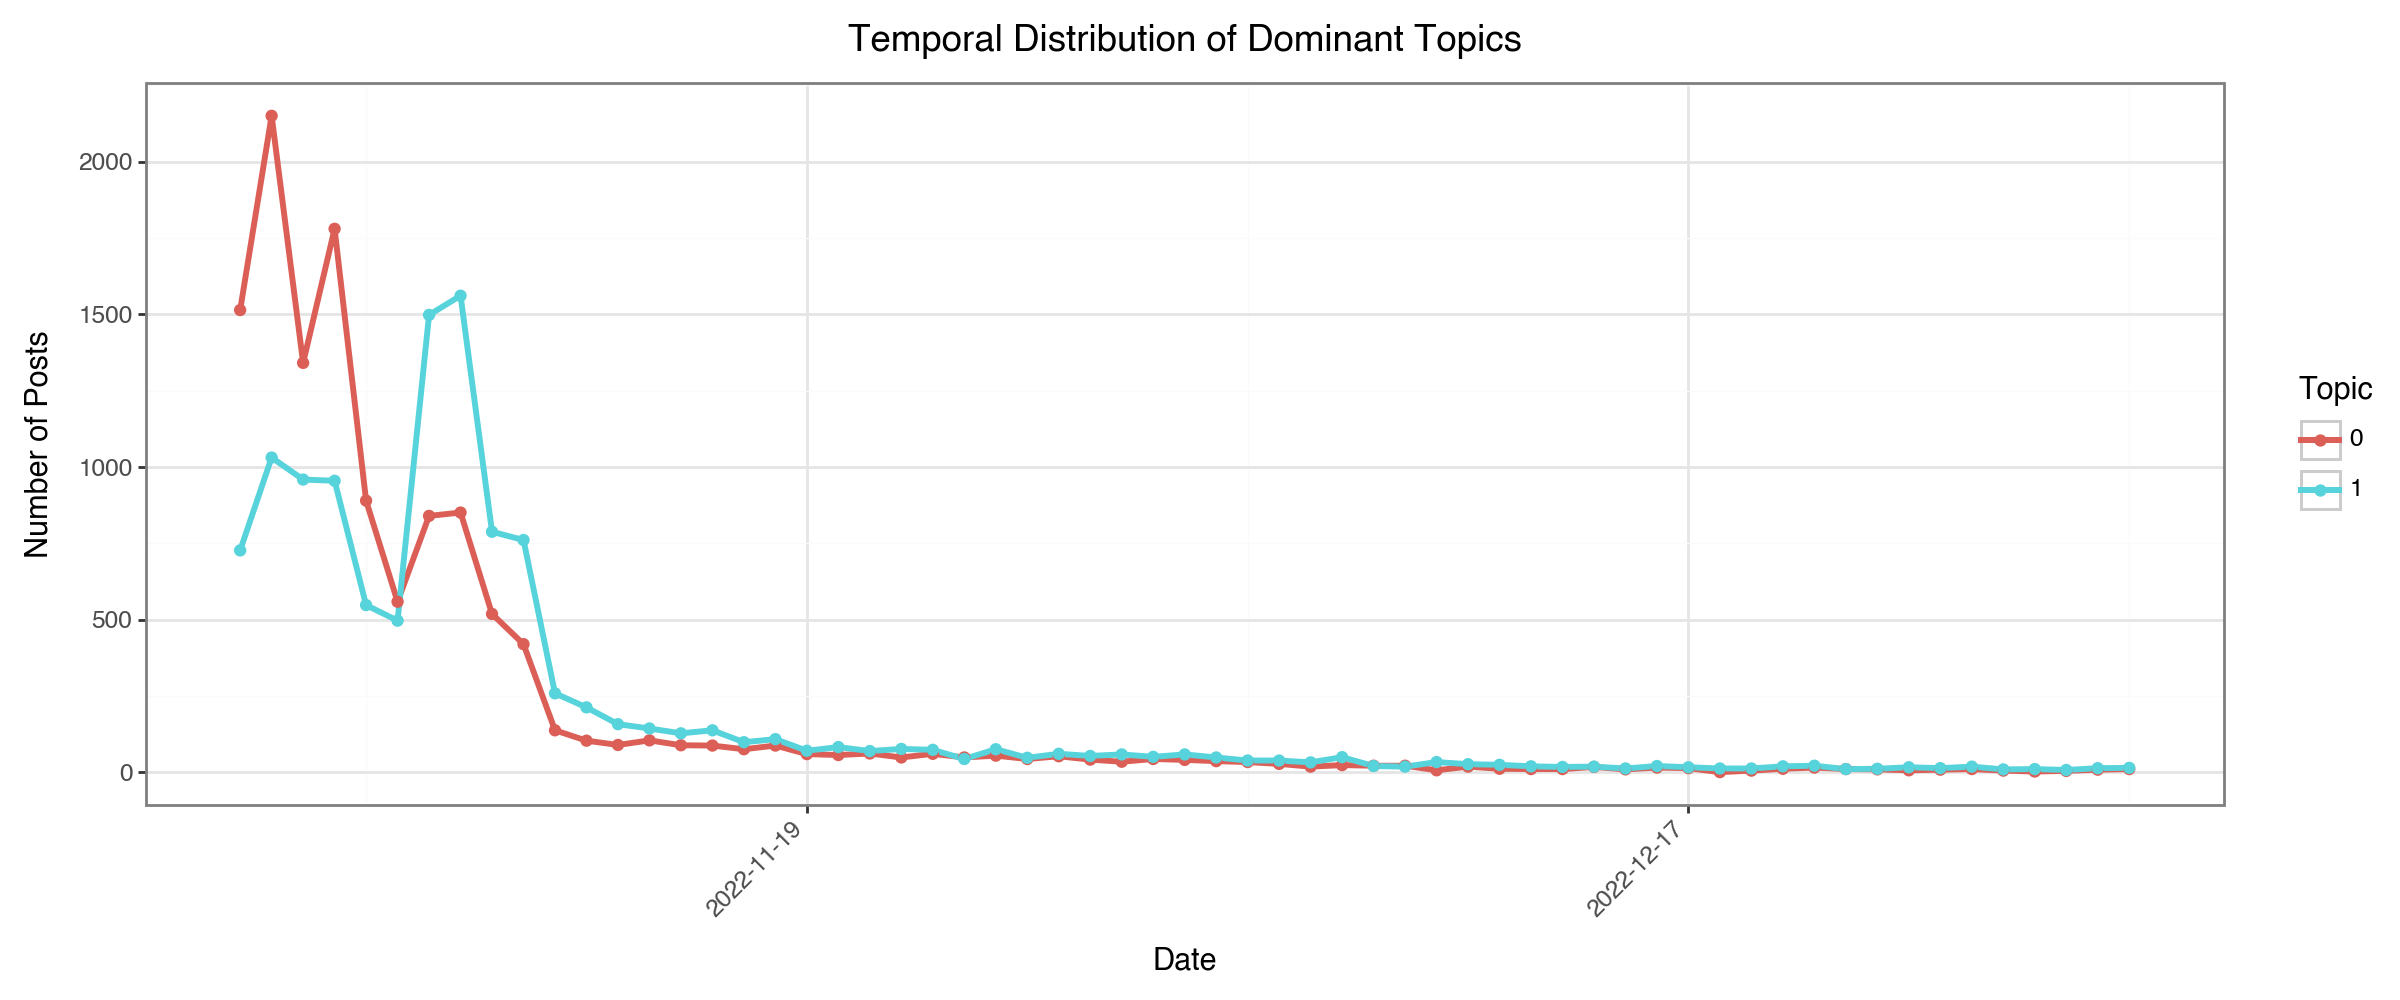

In [139]:
import pandas as pd
from plotnine import *
from mizani.formatters import date_format

# Convert datetime and extract the day
trial_dataset_context["created_utc"] = pd.to_datetime(trial_dataset_context["created_utc"])
trial_dataset_context["day"] = trial_dataset_context["created_utc"].dt.date

# Count posts per day and dominant topic
daily_counts = trial_dataset_context.groupby(["day", "dominant_topic"]).size().reset_index(name="count")
daily_counts["day"] = pd.to_datetime(daily_counts["day"])

# Plot
plot = (
    ggplot(daily_counts, aes(x="day", y="count", color="factor(dominant_topic)"))
    + geom_line(size=1.2)
    + geom_point(size=1.5)
    + labs(
        title="Temporal Distribution of Dominant Topics",
        x="Date",
        y="Number of Posts",
        color="Topic"
    )
    + scale_x_datetime(
        labels=date_format("%Y-%m-%d"),
        date_breaks="4 weeks"  # change to "1 month" for even fewer labels
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, ha="right"),
        figure_size=(12, 5)
    )
)

plot


In [126]:
trial_dataset_context

,post_id,text,author,created_utc,source,dominant_topic,day,month,year,clean_text
16225,UgwYy4ohKTOaKRC2uuB4AaABAg,Honestly with my instincts (I’m not blaming th...,@DustedAway,2023-07-01 02:27:46+00:00,YouTube,1,2023-07-01,2022-12-01,2022,honestly instincts blaming blue kid fault seem...
16227,UgySJ0zRNJZU1V-YJfB4AaABAg,That kid in the blue had to have been the one ...,@BradyDoesntMiss,2023-06-29 20:21:27+00:00,YouTube,1,2023-06-29,2022-12-01,2022,kid blue one kid nice cruz
16230,Ugw_uXYU7m7phru0jrB4AaABAg,If I was the blue guy I’d get up behind him an...,@justakid3592,2023-06-27 16:52:43+00:00,YouTube,1,2023-06-27,2022-12-01,2022,blue guy get behind choke
16231,UgzwKBu1XA3hXjgXLgt4AaABAg,be fr why would you tackle sb with a AR 🤦🏼‍♀,@itsbrigary,2023-06-26 07:58:45+00:00,YouTube,0,2023-06-26,2022-12-01,2022,fr would tackle sb ar
16240,UgyOzUNbLxJs3YTSP-Z4AaABAg,That kid could of tackled him form behide,@Rigo_alpachino505,2023-06-16 19:20:32+00:00,YouTube,1,2023-06-16,2022-12-01,2022,kid could tackled form behide
...,...,...,...,...,...,...,...,...,...,...
222162,Ugxl8qgV2Jpa-AKSxtJ4AaABAg,does anybody know if this detective took the s...,@bigbirdflying6330,2022-11-11 11:21:35+00:00,YouTube,0,2022-11-11,2022-11-01,2022,anybody know detective took stand trial
222166,Ugwe7-NOFXSEjbz_doJ4AaABAg,He's gonna go like Jeffrey Dahmer. I hope he g...,@Obiter3,2022-11-11 10:07:09+00:00,YouTube,0,2022-11-11,2022-11-01,2022,gon na go like jeffrey dahmer hope gets brooms...
222168,Ugzk2C31SBnnPKsUgO94AaABAg,is he always strapped down or is he hurting hi...,@amabelisalinas364,2022-11-11 05:32:39+00:00,YouTube,1,2022-11-11,2022-11-01,2022,always strapped hurting since knows cameras
224484,UgyHzTjbn6W6Kibdu7h4AaABAg,Did anyone else notice little BALD HEADED MEDI...,@twolak1972,2022-07-07 16:32:12+00:00,YouTube,1,2022-07-07,2022-12-01,2022,anyone else notice little bald headed media pa...


In [104]:
# Assicura che il campo created_utc sia in formato datetime
data_with_topics["created_utc"] = pd.to_datetime(data_with_topics["created_utc"])
data_with_topics["day"] = data_with_topics["created_utc"].dt.date

# Filtra per il topic di interesse
topic_id = 2  # o qualsiasi numero tu voglia analizzare
topic_df = data_with_topics[data_with_topics["dominant_topic"] == topic_id]

# Conta i post per giorno
daily_counts = topic_df.groupby("day").size().reset_index(name="count")

# Trova il giorno con più post
peak_day = daily_counts.loc[daily_counts["count"].idxmax(), "day"]
print(f"Giorno con il picco: {peak_day}")


Giorno con il picco: 2022-11-02
